In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import missingno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm
import xgboost
from catboost import CatBoostRegressor
from sklearn import tree
import shap
from autogluon.tabular import TabularDataset, TabularPredictor
import os.path
import sys

In [2]:
parent = os.path.dirname(os.getcwd())
path = parent + '\\data\\'

In [3]:
df_merged=pd.read_csv(path+"df_merged.csv", parse_dates=['date']).drop(columns="Unnamed: 0")

In [4]:
#filter df for europe and remove countries with duplicated values
continent="Europe"
df_cont_merged=df_merged[df_merged["continent"]==continent]
df_cont_merged=df_cont_merged[~df_cont_merged.country_region.isin(["Russia","Serbia","Ukraine"]) ]

In [5]:
#generate a list with mobility areas
areas= ['retail_and_recreation', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential']

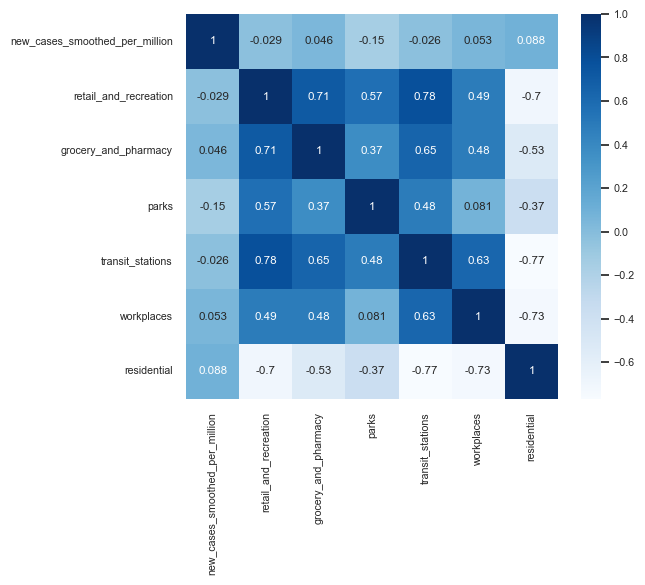

In [6]:
#create a filter version of the df with just some specific columns
df_cont_merged_filter= df_cont_merged.loc[:,['date','new_cases_smoothed_per_million','retail_and_recreation', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential']]
       
#generate a correlation matrix, for some specific of the variables in the df
a=5
font=.7
df_corr=df_cont_merged_filter.corr()
plt.figure(figsize = (a+1, a))
sns.set(font_scale=font)
sns.heatmap(df_corr,  annot = True,cmap = 'Blues')
plt.show()


In [7]:
#define the df that will be modeled later
df_model=df_cont_merged[[ 'date','country_region','new_cases_smoothed_per_million',
      'total_vaccinations','people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations_smoothed',
         'retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']].copy()

In [8]:
#observe the info of the df
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 5669 to 163903
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            32686 non-null  datetime64[ns]
 1   country_region                  32686 non-null  object        
 2   new_cases_smoothed_per_million  32447 non-null  float64       
 3   total_vaccinations              15572 non-null  float64       
 4   people_vaccinated               14944 non-null  float64       
 5   people_fully_vaccinated         14583 non-null  float64       
 6   new_vaccinations_smoothed       21163 non-null  float64       
 7   retail_and_recreation           31887 non-null  float64       
 8   grocery_and_pharmacy            31830 non-null  float64       
 9   parks                           31716 non-null  float64       
 10  transit_stations                32683 non-null  float64       
 11

<AxesSubplot: >

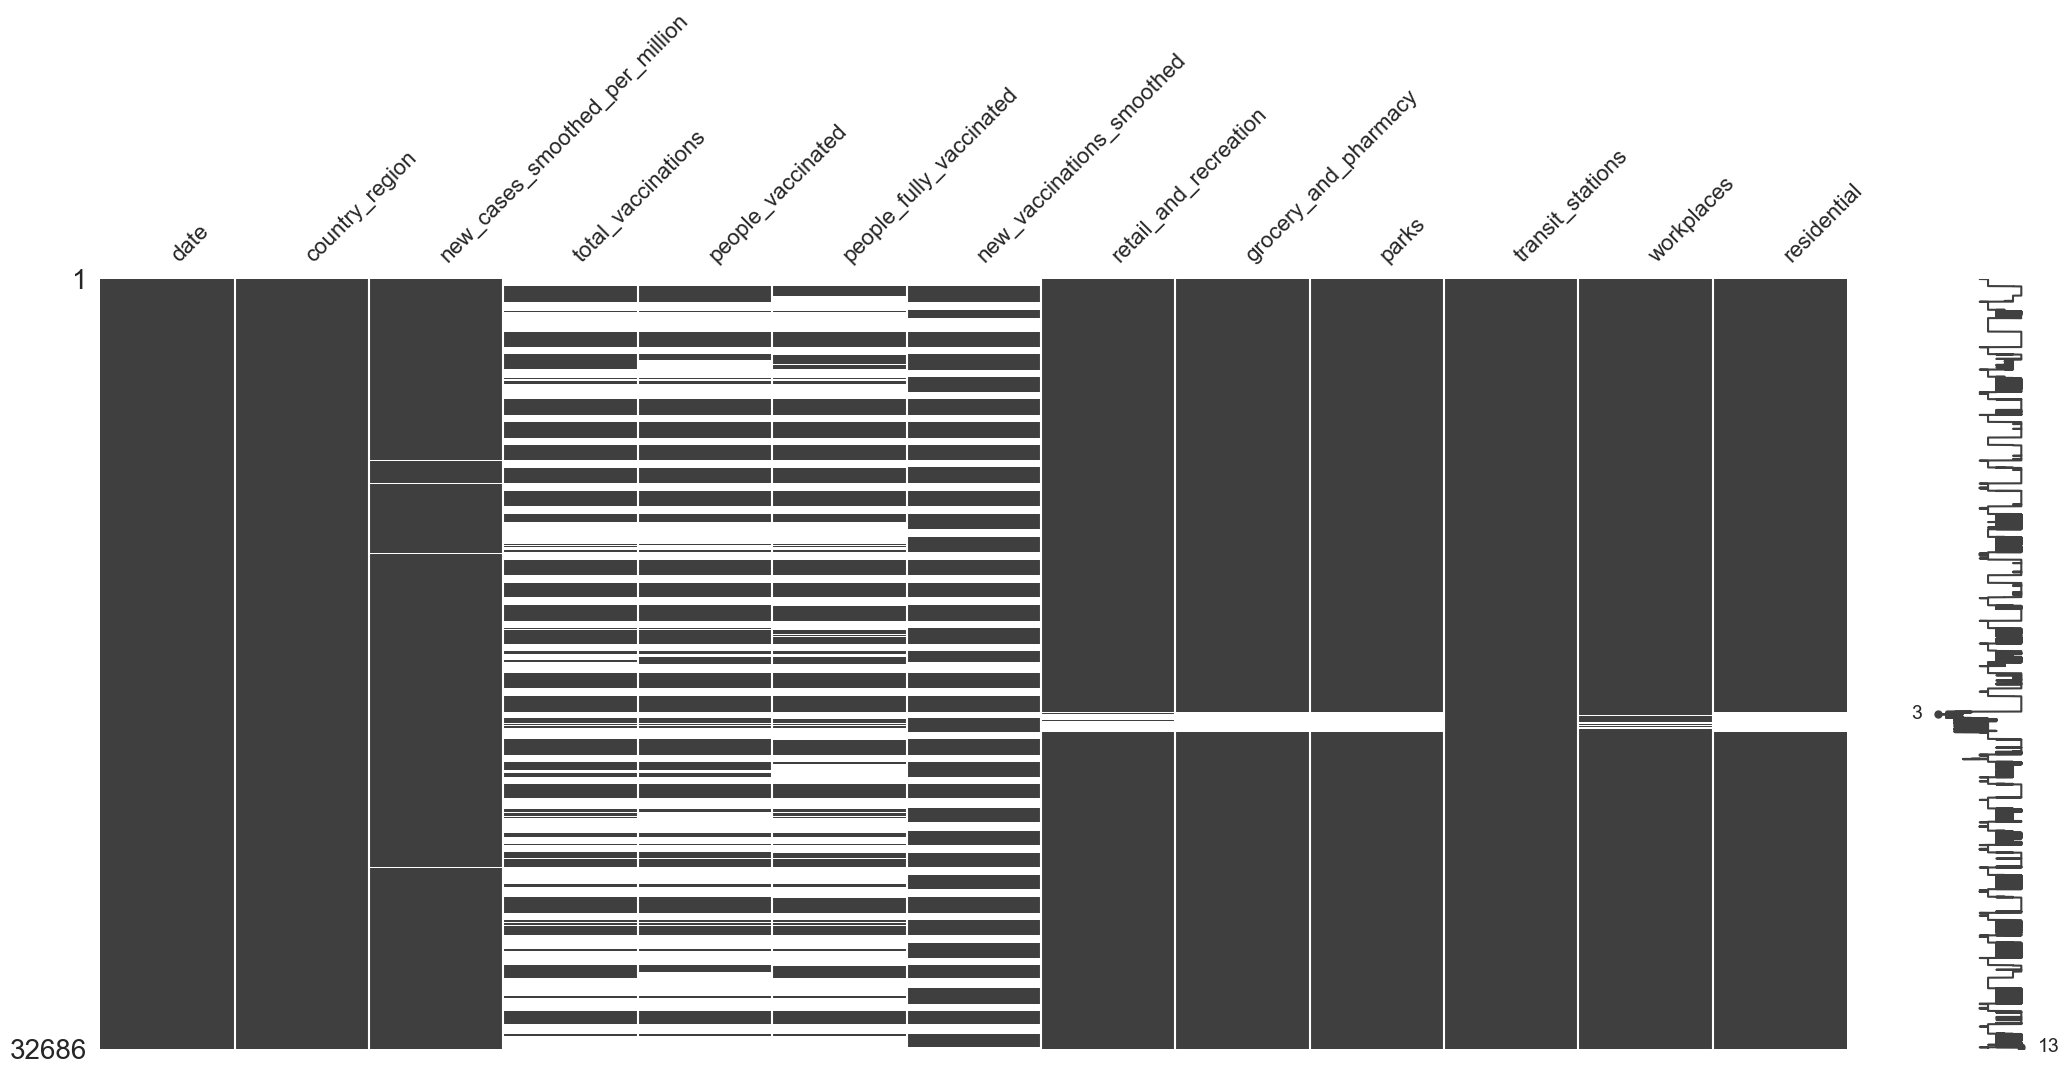

In [9]:
#observe missing values
missingno.matrix(df_model)

In [10]:
#for the case of vaccine variables, the nan values will be replaced with 0, since they are located at the begining of the period, before the vaccination started
df_model.loc[:,('total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations_smoothed'
      )]=df_model.loc[:,('total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated','new_vaccinations_smoothed')].replace(np.nan, 0)

In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32686 entries, 5669 to 163903
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            32686 non-null  datetime64[ns]
 1   country_region                  32686 non-null  object        
 2   new_cases_smoothed_per_million  32447 non-null  float64       
 3   total_vaccinations              32686 non-null  float64       
 4   people_vaccinated               32686 non-null  float64       
 5   people_fully_vaccinated         32686 non-null  float64       
 6   new_vaccinations_smoothed       32686 non-null  float64       
 7   retail_and_recreation           31887 non-null  float64       
 8   grocery_and_pharmacy            31830 non-null  float64       
 9   parks                           31716 non-null  float64       
 10  transit_stations                32683 non-null  float64       
 11

In [12]:
df_model_aux=df_model.copy()
df_model_aux=df_model_aux.set_index("date")
df_model_aux.iloc[:,5:11]=df_model_aux.iloc[:,5:11].rolling(7).mean()

In [13]:
df_model_aux=df_model_aux.reset_index()

In [14]:
#for the rest of the variables, we remove the missing values
df_model_aux=df_model_aux.dropna()

In [15]:
df_model_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31382 entries, 6 to 32685
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            31382 non-null  datetime64[ns]
 1   country_region                  31382 non-null  object        
 2   new_cases_smoothed_per_million  31382 non-null  float64       
 3   total_vaccinations              31382 non-null  float64       
 4   people_vaccinated               31382 non-null  float64       
 5   people_fully_vaccinated         31382 non-null  float64       
 6   new_vaccinations_smoothed       31382 non-null  float64       
 7   retail_and_recreation           31382 non-null  float64       
 8   grocery_and_pharmacy            31382 non-null  float64       
 9   parks                           31382 non-null  float64       
 10  transit_stations                31382 non-null  float64       
 11  wo

In [77]:
#separate the train from the test data.
#the target value is new_cases_smoothed_per_million
seed=1234
X_train, X_test, y_train, y_test=train_test_split(df_model_aux.drop(columns=['new_cases_smoothed_per_million','date','country_region']), df_model_aux['new_cases_smoothed_per_million'], test_size=.33, random_state=seed, shuffle=True)

In [78]:
#generate the first model
mod_ini=lightgbm.LGBMRegressor(random_state = seed) 
mod_ini.fit(X_train, y_train)
y_hat_dt=mod_ini.predict(X_test)

In [68]:
#observe the r2 score of the model 
r2_score(y_test,y_hat_dt)

0.8369368129469429

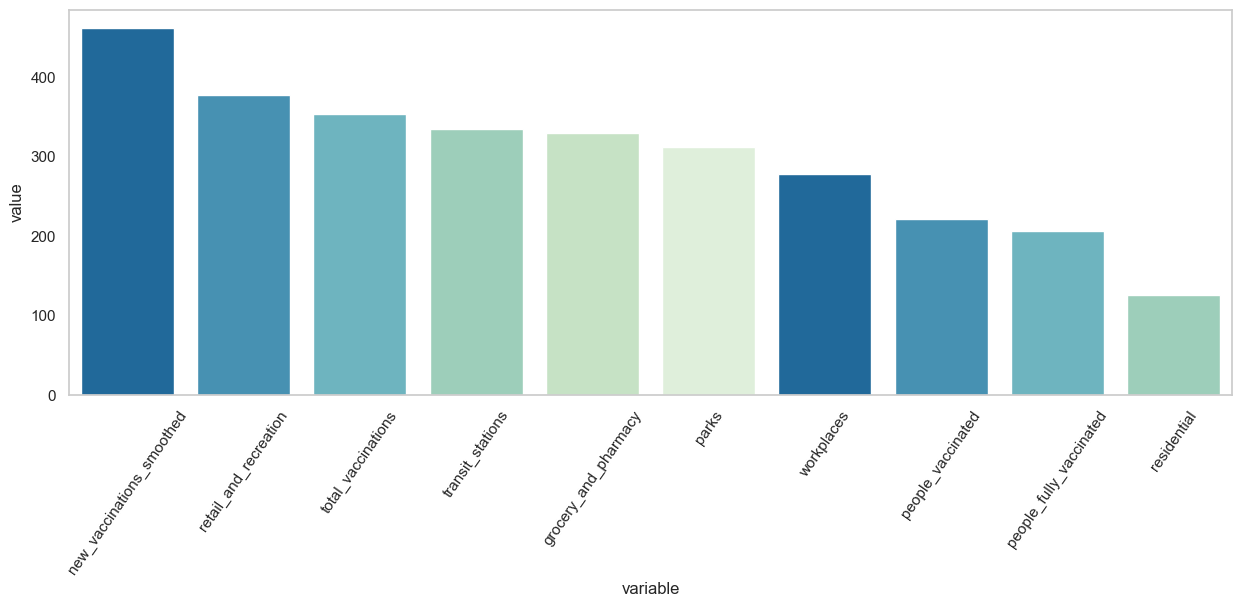

In [84]:
#generate a graph to observe the feature importance for the model

importance_init = mod_ini.feature_importances_
df_results=pd.DataFrame(list(zip(X_train.columns,importance_init)),columns=["variable","value"])
df_results=df_results.sort_values(by="value",ascending=False)

sns.set_style("whitegrid")
plt.subplots(figsize=(15,5))
sns.barplot(data=df_results,x="variable",y='value', palette=sns.color_palette('GnBu_r'))
plt.xticks(rotation=55)
plt.grid(False)

plt.show()


#### Good results are observed in the model, but only because the main predictor is vaccines, this item will be removed to apreciate the effect of mobility

In [20]:
#generate a new df without vaccine data
df_model_wo_vac=df_model_aux.drop(columns=['total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 
       'new_vaccinations_smoothed'])

In [72]:
#separate the train from the test data for the new df
X_train_wov, X_test_wov, y_train_wov, y_test_wov=train_test_split(df_model_wo_vac.drop(columns=['new_cases_smoothed_per_million','date','country_region']), df_model_wo_vac['new_cases_smoothed_per_million'], test_size=.33, random_state=seed, shuffle=True)

In [73]:
#generate a new model
model_wv=lightgbm.LGBMRegressor(random_state = seed)
model_wv.fit(X_train_wov, y_train_wov)
y_hat_wv=model_wv.predict(X_test_wov)

In [74]:
#observe the r2 score of the model 
r2_score(y_test_wov,y_hat_wv)

0.6306078145055993

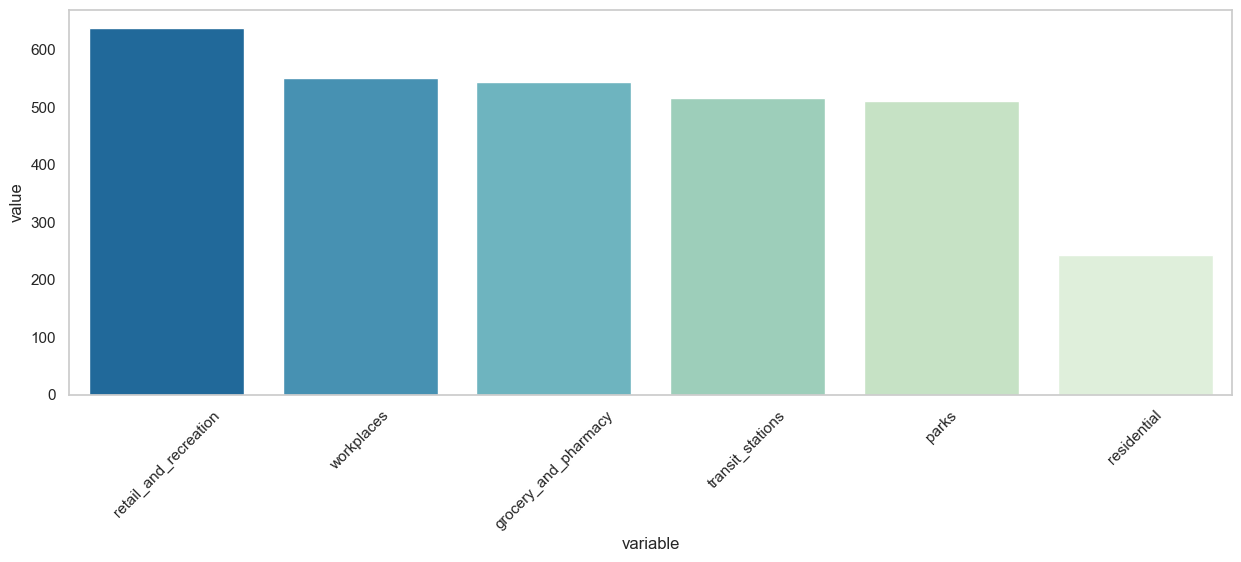

In [76]:
#generate a graph to observe the feature importance for the model
importance_wv = model_wv.feature_importances_
df_results_wv=pd.DataFrame(list(zip(X_train_wov.columns,importance_wv)),columns=["variable","value"])
df_results_wv=df_results_wv.sort_values(by="value",ascending=False)

sns.set_style("whitegrid")
sns.set_palette("Paired_r")
plt.subplots(figsize=(15,5))
#sns.set_context("talk", font_scale=0.7)
#sns.set_style("whitegrid")
sns.barplot(data=df_results_wv,x="variable",y='value', palette=sns.color_palette('GnBu_r'))
plt.xticks(rotation=45)
plt.grid(False)

plt.show()

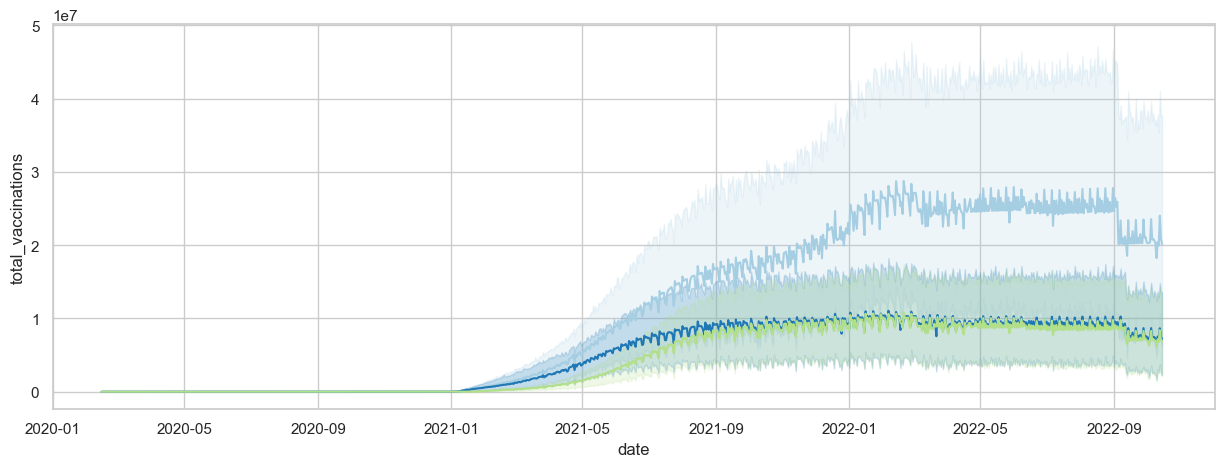

In [85]:
#we observe the vaccination variables

sns.set_style("whitegrid")
sns.set_palette("Paired")
plt.subplots(figsize=(15,5))
sns.lineplot(data=df_model,x="date",y='total_vaccinations')
sns.lineplot(data=df_model,x="date",y='people_vaccinated')
sns.lineplot(data=df_model,x="date",y='people_fully_vaccinated')
plt.xlim(left=datetime.date(2020,1,1))
plt.show()

In [29]:
#We analize the case before vaccines, considering as the period before 2021-04-01
df_bef_vacc=df_model_aux[df_model_aux['date']<'2021-04-01'].copy()
df_after_vacc=df_model_aux[df_model_aux['date']>='2021-04-01'].copy()


In [30]:
#We analize the case after vaccines, considering as the period after 2021-04-01
df_bef_vacc=df_bef_vacc.loc[:,['date','new_cases_smoothed_per_million','retail_and_recreation', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential','country_region']]
df_bef_vacc=df_bef_vacc.dropna()

In [31]:
#separate the train and test data and run the model
X_train, X_test, y_train, y_test=train_test_split(df_bef_vacc.drop(columns=['new_cases_smoothed_per_million','date','country_region']), df_bef_vacc['new_cases_smoothed_per_million'], test_size=.33, random_state = seed, shuffle=True)
bef_vac_lgbm = lightgbm.LGBMRegressor(random_state = seed)
bef_vac_lgbm.fit(X_train, y_train)
y_hat=bef_vac_lgbm.predict(X_test)
r2=r2_score(y_test,y_hat)
mse=mean_squared_error(y_test,y_hat)
#observe the r2 score of the model 
r2

0.6038343965288371

##### Since the effects of moblity are not going to generate an inmediate effect on covid cases, a function will be defined to evaluate different "shifts in time", in which the covid cases will be modeled, but not based on the mobility data of the current day, but in day -t days. The idea is define the "t" value that maximizes the performance of the model

In [32]:
path_funct = parent + '\\functions\\'

sys.path.insert(1, path_funct)


In [99]:
import model_functions_upd as mf
from importlib import reload 
reload(mf)

<module 'model_functions_upd' from 'C:\\Users\\jesic\\OneDrive\\MADS\\S1\\Introduction to Data Analytics\\Project\\Mobility\\Organized_code\\GIT\\functions\\model_functions_upd.py'>

In [34]:
shift_days, r2_list, mse_list = mf.run_models(lightgbm.LGBMRegressor(),df_bef_vacc ,50, areas) 

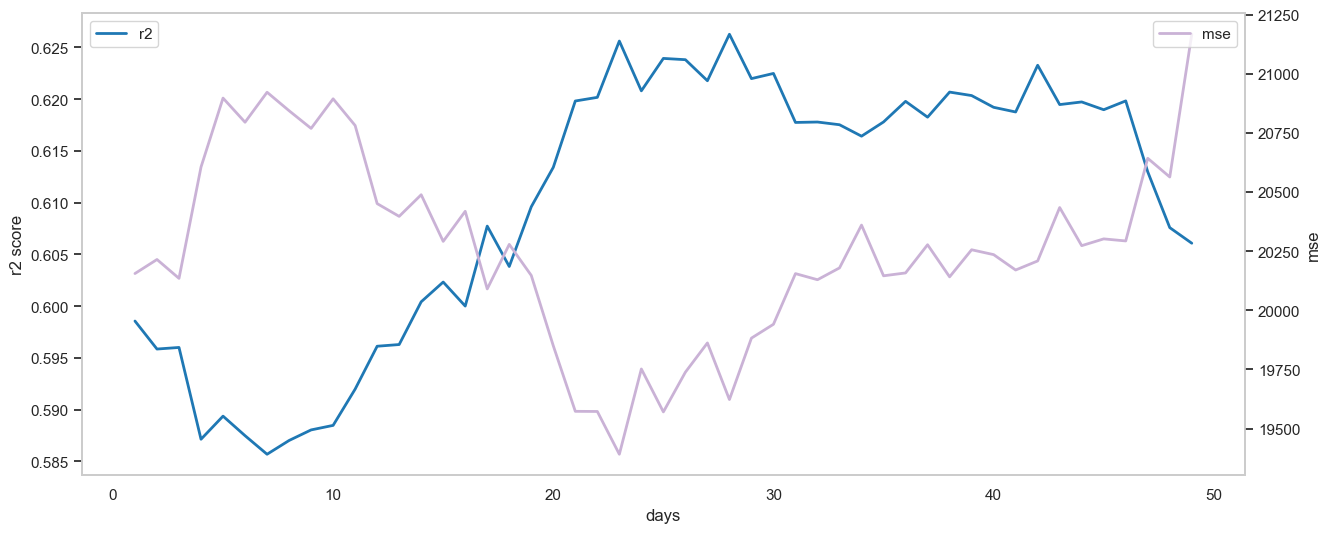

In [35]:
sns.set_style("whitegrid")
sns.set_palette("Paired_r")
palette=sns.color_palette()
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.grid(False)
sns.lineplot(x=shift_days,y=r2_list, color=palette[5], label="r2",linewidth = 2) #deepskyblue color="dodgerblue"
ax2=ax1.twinx()
sns.lineplot(x=shift_days,y=mse_list, color=palette[1], label="mse",linewidth = 2) #color="mediumorchid",
ax2.grid(False)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("days", fontsize=12)
ax1.set_ylabel("r2 score", fontsize=12)
ax2.set_ylabel("mse", fontsize=12)
plt.show()

In [36]:
shift_days, r2_list, mse_list = mf.run_models(RandomForestRegressor(max_depth=20, n_jobs=-1),df_bef_vacc ,50, areas) 

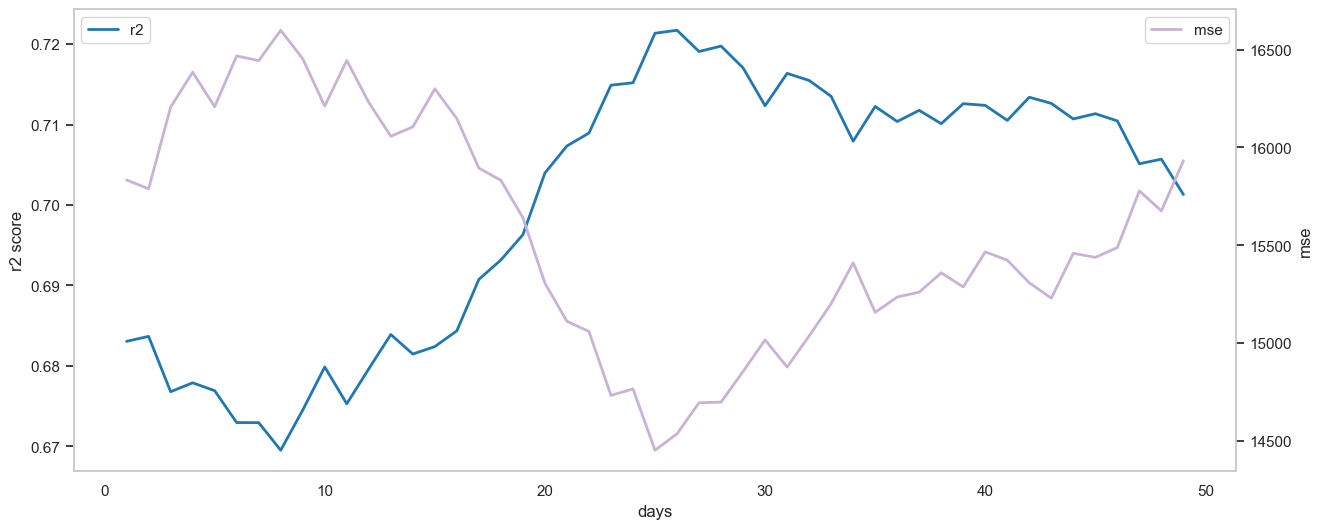

In [37]:
sns.set_style("whitegrid")
sns.set_palette("Paired_r")
palette=sns.color_palette()
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.grid(False)
sns.lineplot(x=shift_days,y=r2_list, color=palette[5], label="r2",linewidth = 2) #deepskyblue color="dodgerblue"
ax2=ax1.twinx()
sns.lineplot(x=shift_days,y=mse_list, color=palette[1], label="mse",linewidth = 2) #color="mediumorchid",
ax2.grid(False)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("days", fontsize=12)
ax1.set_ylabel("r2 score", fontsize=12)
ax2.set_ylabel("mse", fontsize=12)
plt.show()

In [40]:
#We analize the effect after vaccines
df_after_vacc=df_after_vacc.loc[:,['date','new_cases_smoothed_per_million','retail_and_recreation', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential','country_region']]# 'people_fully_vaccinated'
df_after_vacc=df_after_vacc.dropna()

In [41]:
#apply the function for the data after vaccine, for the random forest
shift_days, r2_list, mse_list = mf.run_models(lightgbm.LGBMRegressor(), df_after_vacc ,15, areas)

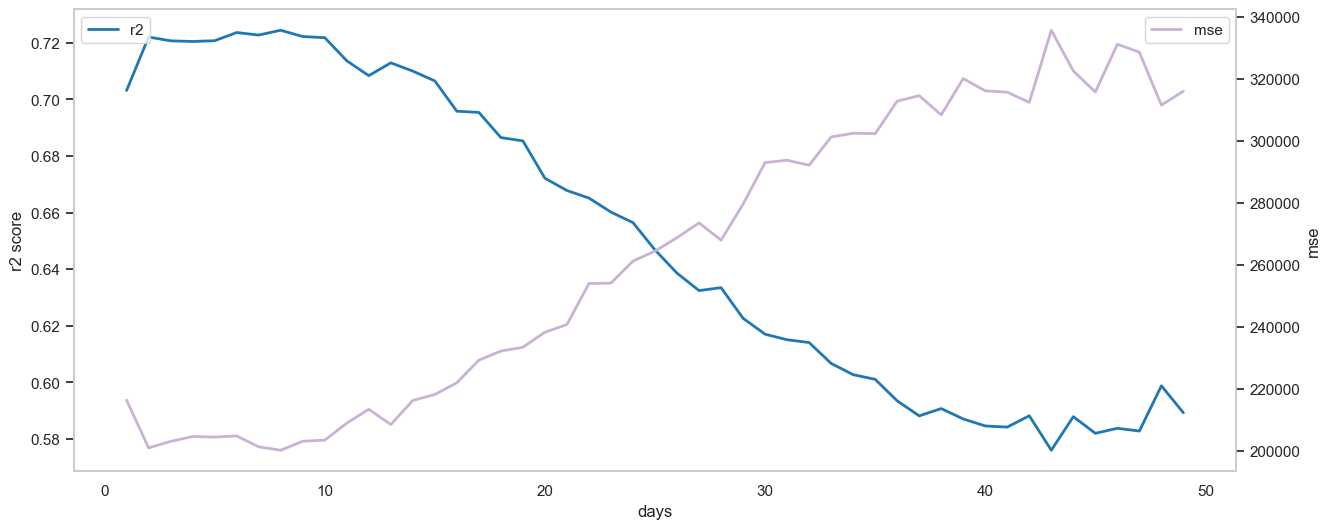

In [42]:
sns.set_style("whitegrid")
sns.set_palette("Paired_r")
palette=sns.color_palette()
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.grid(False)
sns.lineplot(x=shift_days,y=r2_list, color=palette[5], label="r2",linewidth = 2) #deepskyblue color="dodgerblue"
ax2=ax1.twinx()
sns.lineplot(x=shift_days,y=mse_list, color=palette[1], label="mse",linewidth = 2) #color="mediumorchid",
ax2.grid(False)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("days", fontsize=12)
ax1.set_ylabel("r2 score", fontsize=12)
ax2.set_ylabel("mse", fontsize=12)
plt.show()

In [43]:
#apply the function for the data after vaccine, for the random forest
shift_days, r2_list, mse_list = mf.run_models(RandomForestRegressor(max_depth=20, n_jobs=-1),df_after_vacc ,20, areas) #lightgbm.LGBMRegressor(


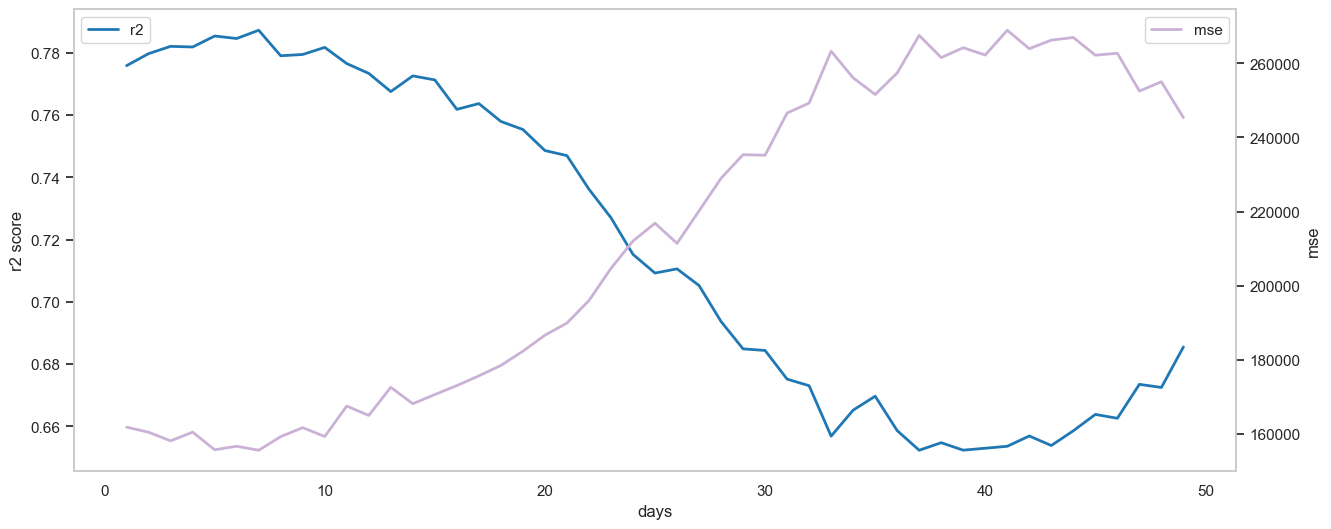

In [44]:
sns.set_style("whitegrid")
sns.set_palette("Paired_r")
palette=sns.color_palette()
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.grid(False)
sns.lineplot(x=shift_days,y=r2_list, color=palette[5], label="r2",linewidth = 2) #deepskyblue color="dodgerblue"
ax2=ax1.twinx()
sns.lineplot(x=shift_days,y=mse_list, color=palette[1], label="mse",linewidth = 2) #color="mediumorchid",
ax2.grid(False)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("days", fontsize=12)
ax1.set_ylabel("r2 score", fontsize=12)
ax2.set_ylabel("mse", fontsize=12)
plt.show()

### Model Before Vaccines

In [86]:
df_shift_bef=mf.shift_df(df_bef_vacc,25)
df_bef_vacc=df_bef_vacc.dropna()

In [87]:
X_train, X_test, y_train, y_test=train_test_split(df_shift_bef.drop(columns=['new_cases_smoothed_per_million','date','country_region']), df_shift_bef['new_cases_smoothed_per_million'], test_size=.33, random_state = seed, shuffle=True)
bef_vac_rf = RandomForestRegressor(max_depth=15,random_state = seed) 
bef_vac_rf.fit(X_train, y_train)
y_hat=bef_vac_rf.predict(X_test, )
r2=r2_score(y_test,y_hat)
mse=mean_squared_error(y_test,y_hat)
r2

0.6993391805013325

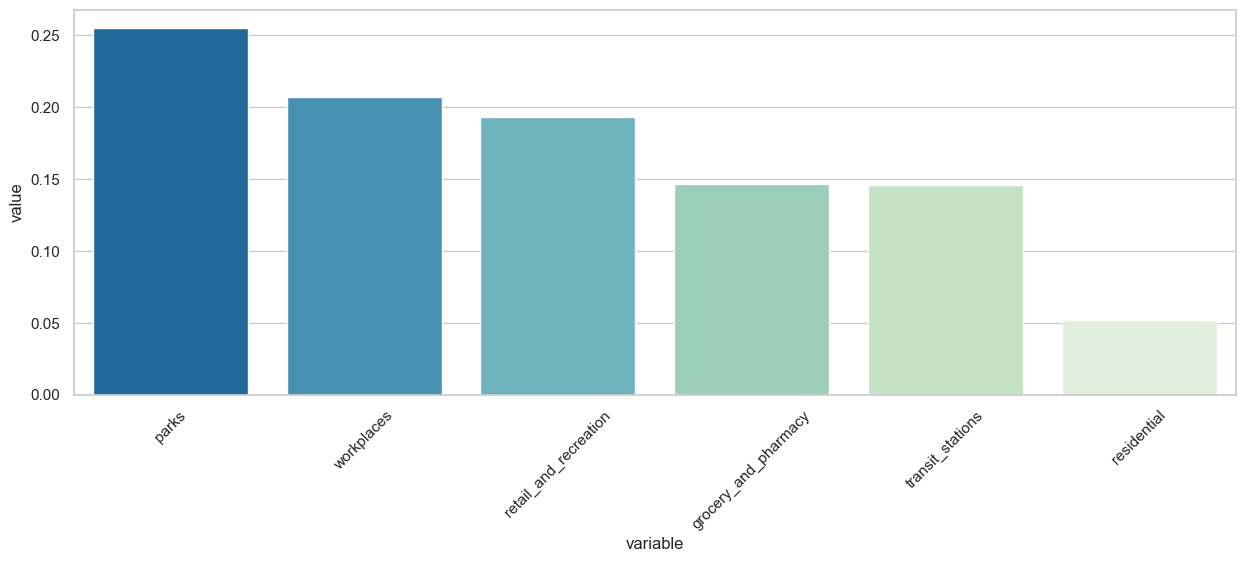

In [47]:
#generate a graph to observe the feature importance for the model
importance_dt = bef_vac_rf.feature_importances_
df_results_dt=pd.DataFrame(list(zip(X_train.columns,importance_dt)),columns=["variable","value"])
df_results_dt=df_results_dt.sort_values(by="value",ascending=False)

sns.set_palette("Paired")

plt.subplots(figsize=(15,5))
sns.barplot(data=df_results_dt,x="variable",y='value', palette=sns.color_palette('GnBu_r'))
plt.xticks(rotation=45)
plt.show()


In [48]:
explainer = shap.Explainer(bef_vac_rf.predict, X_test)
shap_values = explainer(X_test)

Exact explainer: 3900it [06:04, 10.50it/s]                                                                             


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


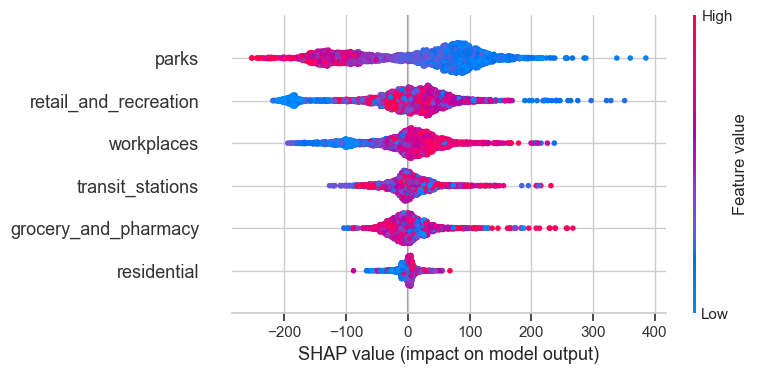

In [49]:
shap.summary_plot(shap_values)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


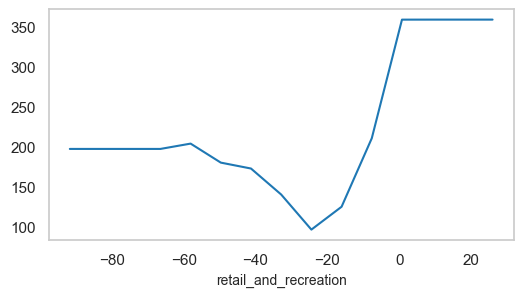

In [111]:

mf.graf_curvas_1_var(bef_vac_rf,X_train,0,15)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


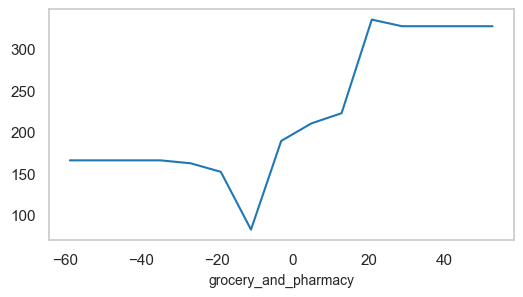

In [110]:
mf.graf_curvas_1_var(bef_vac_rf,X_train,1,15)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


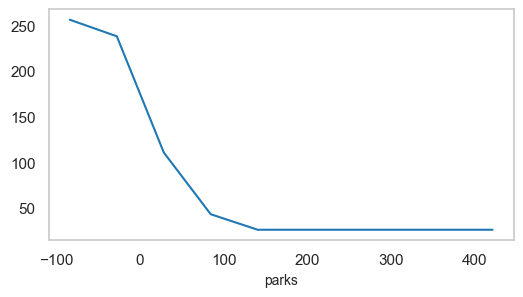

In [101]:
mf.graf_curvas_1_var(bef_vac_rf,X_train,2)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


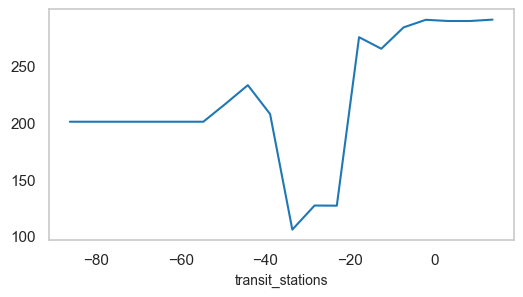

In [105]:
mf.graf_curvas_1_var(bef_vac_rf,X_train,3,20)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


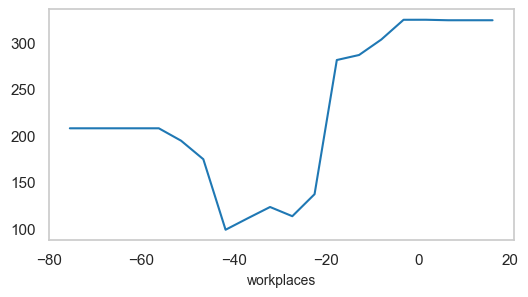

In [107]:
mf.graf_curvas_1_var(bef_vac_rf,X_train,4,20)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


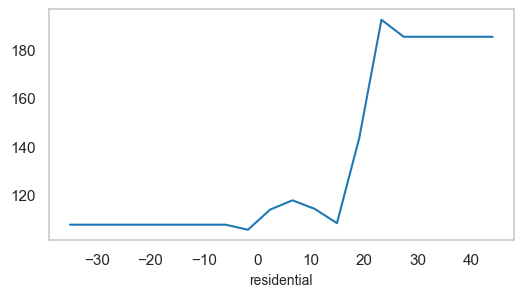

In [108]:
mf.graf_curvas_1_var(bef_vac_rf,X_train,5,20)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


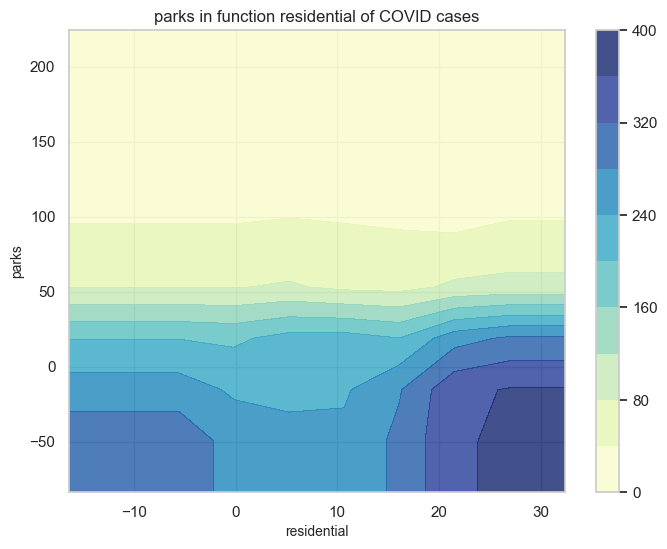

In [112]:
mf.graf_curvas_nivel(bef_vac_rf,X_train,5,2)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


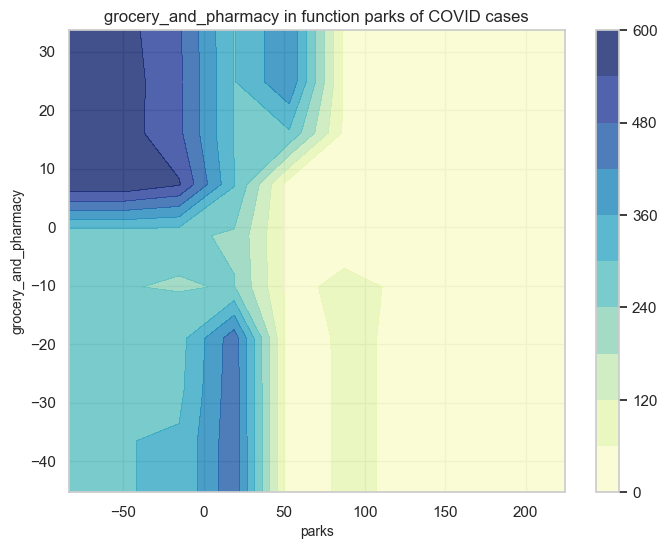

In [114]:
mf.graf_curvas_nivel(bef_vac_rf,X_train,2,1)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


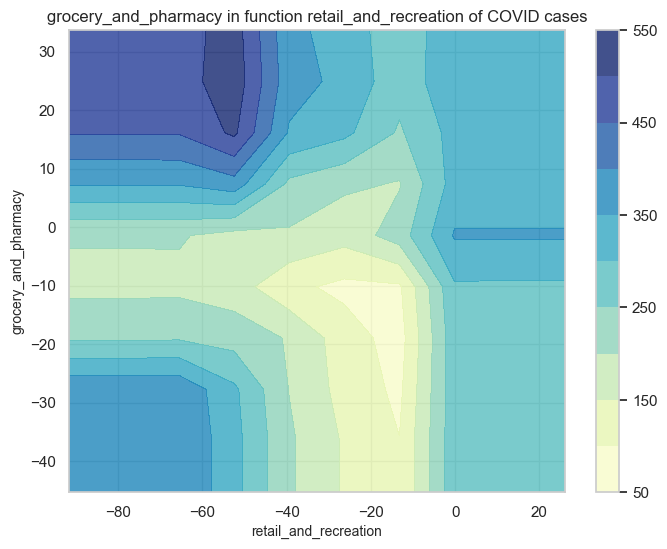

In [116]:
mf.graf_curvas_nivel(bef_vac_rf,X_train,0,1)

### Model After Vaccines

In [117]:
df_shift_aft=mf.shift_df(df_after_vacc,7)
df_shift_aft=df_shift_aft.dropna()
df_shift_aft

,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,country_region,new_cases_smoothed_per_million
0,2021-04-01,-35.857143,2.000000,42.000000,-30.000000,-29.857143,10.0,Austria,316.520
1,2021-04-02,-37.285714,2.571429,38.142857,-32.285714,-32.285714,14.0,Austria,308.179
2,2021-04-03,-39.714286,1.714286,33.714286,-34.857143,-33.285714,9.0,Austria,298.814
3,2021-04-04,-41.714286,-1.142857,28.714286,-37.285714,-33.714286,5.0,Austria,301.227
4,2021-04-05,-48.142857,-13.142857,35.714286,-40.714286,-40.571429,22.0,Austria,287.612
...,...,...,...,...,...,...,...,...,...
18301,2022-10-04,6.000000,38.000000,38.571429,13.285714,1.571429,1.0,Slovakia,139.226
18302,2022-10-05,5.714286,37.571429,37.285714,13.285714,2.000000,2.0,Slovakia,133.885
18303,2022-10-06,5.714286,37.142857,41.285714,13.714286,2.428571,1.0,Slovakia,130.847
18304,2022-10-07,5.857143,37.000000,47.714286,14.000000,2.571429,1.0,Slovakia,124.341


In [118]:
X_train, X_test, y_train, y_test=train_test_split(df_shift_aft.drop(columns=['date','new_cases_smoothed_per_million','country_region']), df_shift_aft['new_cases_smoothed_per_million'], test_size=.33, shuffle=True)
aft_vac_lgbm =RandomForestRegressor(max_depth=20)
# lightgbm.LGBMRegressor(random_state = seed)
aft_vac_lgbm.fit(X_train, y_train)
y_hat=aft_vac_lgbm.predict(X_test)
r2=r2_score(y_test,y_hat)
mse=mean_squared_error(y_test,y_hat)
#observe the r2
r2

0.7792293406319726

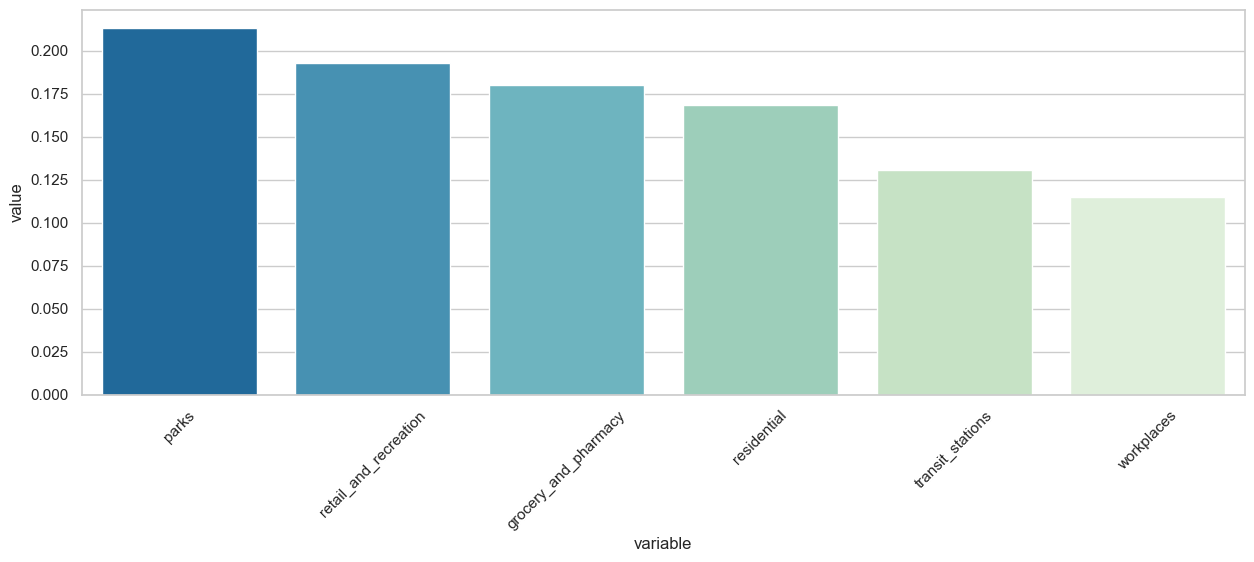

In [119]:
#generate a graph to observe the feature importance for the model
importance_dt = aft_vac_lgbm.feature_importances_
df_results_dt=pd.DataFrame(list(zip(X_train.columns,importance_dt)),columns=["variable","value"])
df_results_dt=df_results_dt.sort_values(by="value",ascending=False)

sns.set_palette("Paired")

plt.subplots(figsize=(15,5))
sns.barplot(data=df_results_dt,x="variable",y='value', palette=sns.color_palette('GnBu_r'))
plt.xticks(rotation=45)
plt.show()


In [58]:
explainer = shap.Explainer(aft_vac_lgbm.predict, X_test)
shap_values = explainer(X_test)

Exact explainer: 6042it [11:57,  8.29it/s]                                                                             


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


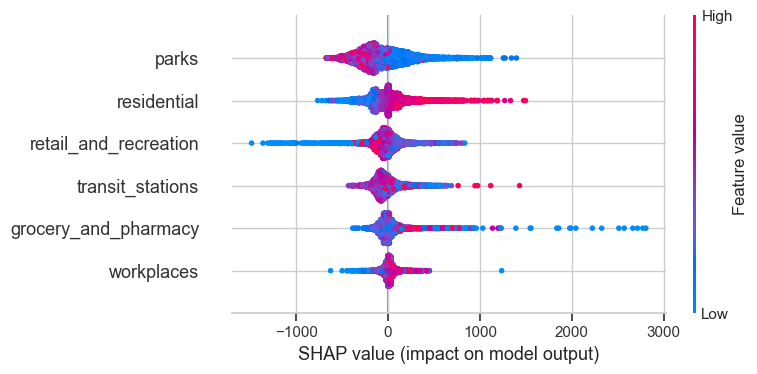

In [59]:
shap.summary_plot(shap_values)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


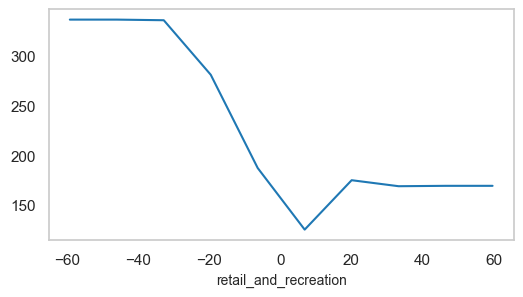

In [120]:
mf.graf_curvas_1_var(aft_vac_lgbm,X_train,0)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


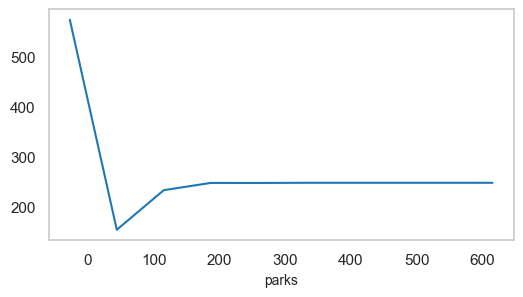

In [121]:
mf.graf_curvas_1_var(aft_vac_lgbm,X_train,2)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


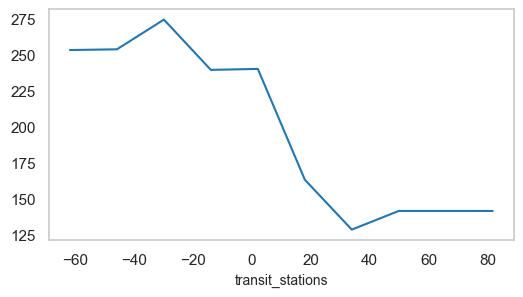

In [122]:
mf.graf_curvas_1_var(aft_vac_lgbm,X_train,3)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


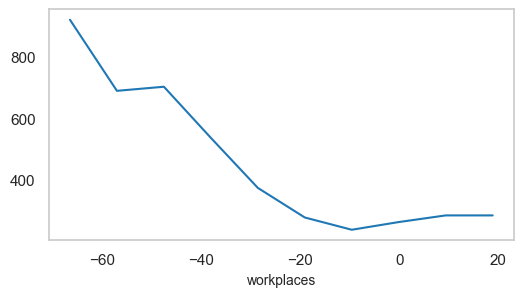

In [123]:
mf.graf_curvas_1_var(aft_vac_lgbm,X_train,4)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


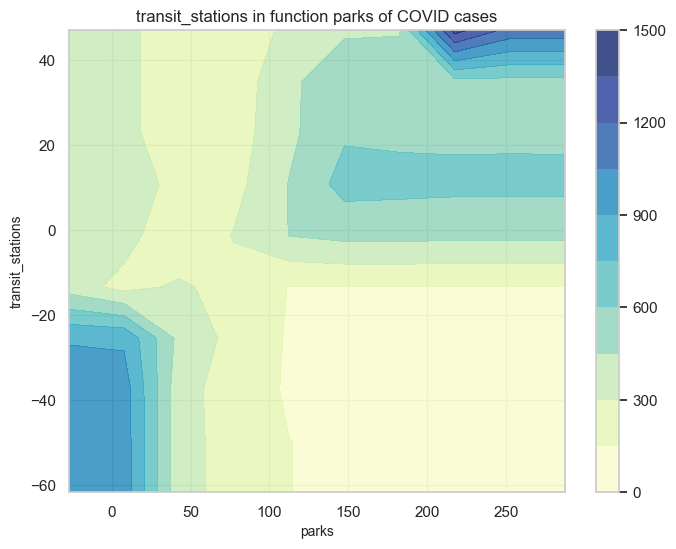

In [124]:
mf.graf_curvas_nivel(aft_vac_lgbm,X_train,2,3)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


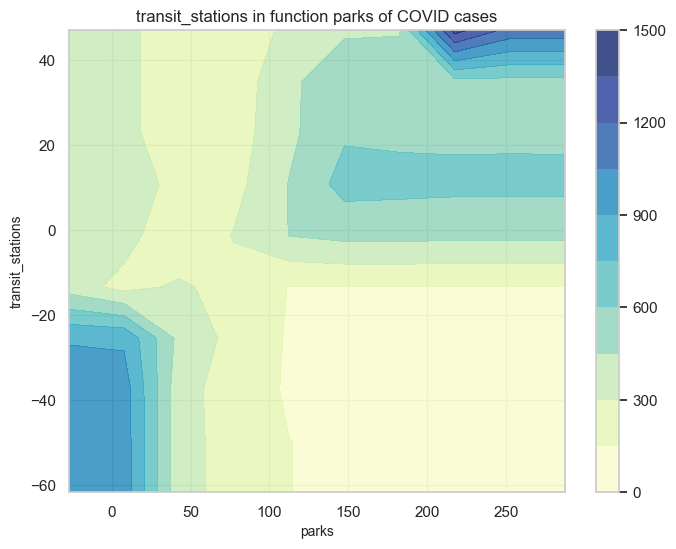

In [125]:
mf.graf_curvas_nivel(aft_vac_lgbm,X_train,2,3)